In [15]:
import pandas as pd
import json
import csv
import numpy as np
import matplotlib.pyplot as plt      
import math
import geopandas
from shapely.geometry import Point
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression


In [16]:
nadlan_df = pd.read_csv("Data/Nadlan_clean.csv",index_col=0)
yad2_df = pd.read_csv("Data/Yad2_clean.csv",index_col=0)


def prep_the_data_for_data_vialuzation(df):
    df['PRICE_PER_METER'] = (df['Price'] / df['Size']).round()
    df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y')

    df['Year'] = df['Date'].dt.strftime('%Y')
    df['Year'] = df['Year'].astype(int)
    df = df[(df['Year'] >= 2003) & (df['Year'] < 2024)]
    df = remove_outliers(df)
    return df

def remove_outliers(df):
    cols = ['Price' , 'PRICE_PER_METER']
    for col in cols:        
        q1, q3 = np.percentile(df[col], [25, 75])
        iqr = q3 - q1
        lower_bound = q1 -(1.5 * iqr) 
        upper_bound = q3 +(1.5 * iqr)
        df = df[(df[col] > lower_bound) & (df[col] < upper_bound)]
        
    # Add after this filer
    df = df[df['Price'] > 800000]
    df = df[df['Price'] < 12000000]
    df = df[df['Size'] < 350]
    df = df[df['Size'] > 25]
    df = df[df['Build_year'] > 1910]
    return df


nadlan_df = prep_the_data_for_data_vialuzation(nadlan_df)

In [17]:
def calculate_price_increase(df):
    df_2022 = df[df['Year'] == 2022]
    price_2022 = df_2022['Price'].mean()
    price_increase = {}
    
    for year in df['Year'].unique():
        if year == 2022:
            continue
        df_year = df[df['Year'] == year]
        price_year = df_year.mean()['Price']
        percent_increase = ((price_year - price_2022) / price_2022) * 100
        price_increase[year] = -1*(percent_increase)
        
    sorted_price_increase = {k: v for k, v in sorted(price_increase.items(), key=lambda item: item[0])}
    return price_increase

def add_predicted_price(df):
    price_increase = calculate_price_increase(df)
    df['Predicted_Price'] = df.apply(lambda row: row['Price'] * (1 + price_increase.get(row['Year'], 0)/100), axis=1)
    df['Predicted_Price'] = df['Predicted_Price'].astype(np.int32)
    df['Percentage_Change'] = df.apply(lambda row: price_increase.get(row['Year'], 0), axis=1)
    df['Percentage_Change'] = df['Percentage_Change'].round(3)
    return df

# nadlan_df = add_predicted_price(nadlan_df)


In [18]:
from sklearn.cluster import KMeans

def k_mean_grap(df):
    df = df.drop(columns=['Home_number','Rebuilt','UniqueId','Gush','Helka','Tat' ,'New','Neighborhood','PRICE_PER_METER','Type','Street','Date'], axis=1)
#     df = df.dropna(subset=['Long','Lat','Rooms','Floor','Floors','Year','Build_year']).reset_index(drop=True)
    df = df.dropna().reset_index(drop=True)    
    df['Build_year'] = df['Build_year'].astype(np.int32)
    df = df[df['Year'] == 2020]
    kmeans = KMeans(n_clusters=10, random_state=22).fit(df)

    # Add the cluster labels to the DataFrame
    df['cluster'] = kmeans.labels_
    
    # Plot the clusters
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.scatter(df['Long'], df['Lat'], c=df['cluster'], cmap='viridis')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Real Estate Clusters')

    plt.show()

        
# k_mean_grap(nadlan_df)

In [19]:
from scipy.stats import boxcox

def get_hist(df):
    cols = ['Size', 'Long', 'Distance_sea', 'PRICE_PER_METER']
    for col in cols:
        df.hist(column=col , bins=20)

# get_hist(nadlan_df)

# cols = ['Rooms','Size','Build_year','Long','Lat','Distance_sea','PRICE_PER_METER','Year']
# new_cols = ['Size', 'Long', 'Distance_sea', 'PRICE_PER_METER']



In [20]:
import plotly.express as px

def create_3d_plot(df):
    # Filter for rows with year == 2020
    df_2020 = df[df['Year'] == 2020]

    # Create 3D scatter plot with price, lat, and long as x, y, and z axes respectively
    fig = px.scatter_3d(df_2020, x='Long', y='Lat', z='PRICE_PER_METER')

    # Set axis labels and title
    fig.update_layout(scene=dict(xaxis_title='Longitude', yaxis_title='Latitude', zaxis_title='PRICE_PER_METER'),
                      title='Real Estate Transactions in 2020')

    fig.show()

# create_3d_plot(df)

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_real_estate(df):
    # filter the dataframe to only include rows with year 2020
    df = df[df['Year'] == 2020]
    
    # calculate the average price per square meter by neighborhood and year
    avg_price_df = df.groupby(['Neighborhood', 'Year']).mean()[['PRICE_PER_METER']].reset_index()
    
    # assign colors to each neighborhood based on average price per square meter
    color_scale = px.colors.sequential.Viridis
    min_price, max_price = avg_price_df['PRICE_PER_METER'].min(), avg_price_df['PRICE_PER_METER'].max()
    color_map = {neighborhood: color_scale[int((price - min_price) / (max_price - min_price) * (len(color_scale) - 1))] for neighborhood, price in zip(avg_price_df['Neighborhood'], avg_price_df['PRICE_PER_METER'])}
    df['color'] = df['Neighborhood'].map(color_map)
    
    # create the 3D scatter plot
    fig = px.scatter_3d(df, x='Long', y='Lat', z='PRICE_PER_METER', color='color', hover_data=['Neighborhood'])
    
    # show the plot
    fig.show()

# plot_real_estate(nadlan_df)
    

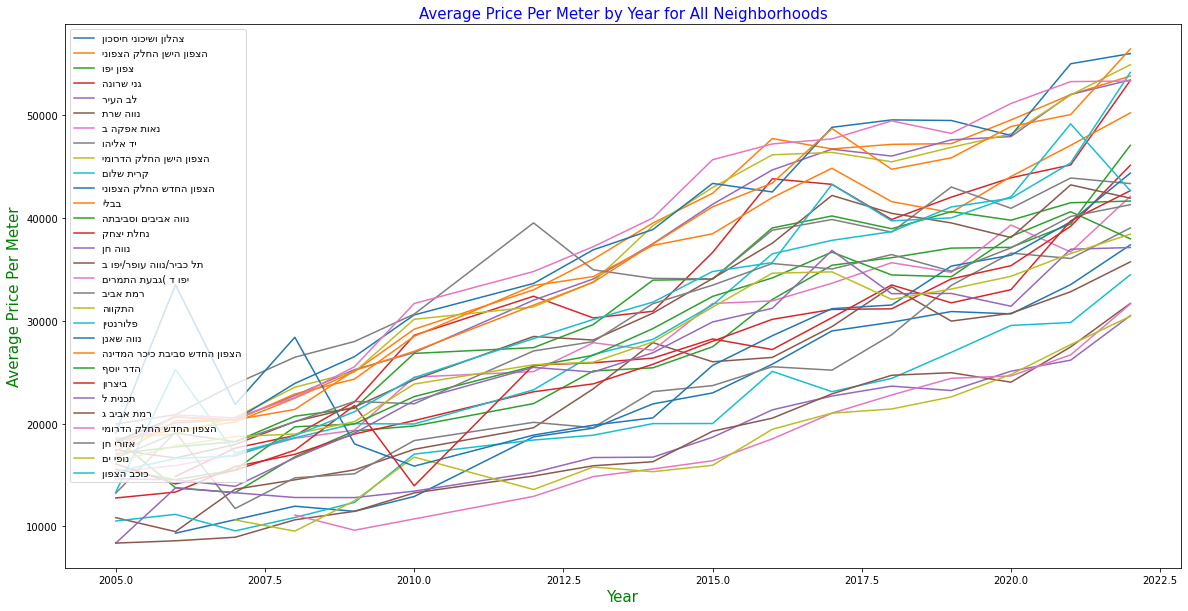

In [22]:

def remove_small_amount_deals(df, threshold=500):
    neighborhoods = df['Neighborhood'].value_counts()
    to_remove = neighborhoods[neighborhoods < threshold].index
    df = df[~df['Neighborhood'].isin(to_remove)].reset_index(drop=True)
    df = df[df['Year'] < 2023]
    df = df[df['Year'] > 2004]
    return df 

def line_plot_neighborhoods(df):  
    df = df.dropna(subset=['Price', 'Neighborhood', 'Size']).reset_index(drop=True)
    df = remove_small_amount_deals(df)
    neighborhoods = df['Neighborhood'].unique()
    
    neighborhoods_change_price = {}
    for neighborhood in neighborhoods:
        df_neighborhood = df[df['Neighborhood'] == neighborhood]
        if len(df_neighborhood) < 10:
            continue
        avg_price_meter_data = df_neighborhood.groupby(['Year']).mean()['PRICE_PER_METER']
        neighborhoods_change_price[neighborhood] = avg_price_meter_data
        
    plt.figure(figsize=(20,10))    
    plt.title('Average Price Per Meter by Year for All Neighborhoods', color='b', fontsize=15)
    plt.xlabel('Year', color='g', fontsize=15)
    plt.ylabel('Average Price Per Meter', color='g', fontsize=15)
    
    for key, values in neighborhoods_change_price.items():
        plt.plot(values.index, values, label=key[::-1])
        
    plt.legend()
    plt.show()

line_plot_neighborhoods(nadlan_df)
                 


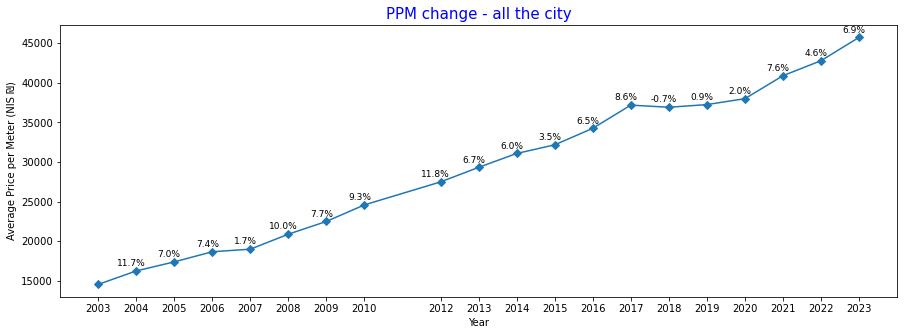

In [23]:
def plot_price_change(df):
    df_grouped = df.groupby(['Year']).mean()
    plt.figure(figsize=(15,5))  
    plt.title('PPM change - all the city', color = 'b', fontsize = 15)

    plt.plot(df_grouped.index, df_grouped['PRICE_PER_METER'], '-D')
    plt.xlabel('Year')
    plt.ylabel('Average Price per Meter (NIS ₪)')
    plt.xticks(df_grouped.index)
    
    # Calculate the percentage change
    price_change = (df_grouped['PRICE_PER_METER'].diff() / df_grouped['PRICE_PER_METER'].shift(1)) * 100
    price_change.dropna(inplace=True)
    # Add the change as text annotations
    for i, change in enumerate(price_change):
        x = price_change.index[i]
        y = df_grouped.loc[x, 'PRICE_PER_METER']
        plt.annotate("{:.1f}%".format(change), (x, y), textcoords="offset points", xytext=(-5,5), ha='center', fontsize=9)
    
    
    plt.show()
    

plot_price_change(nadlan_df)

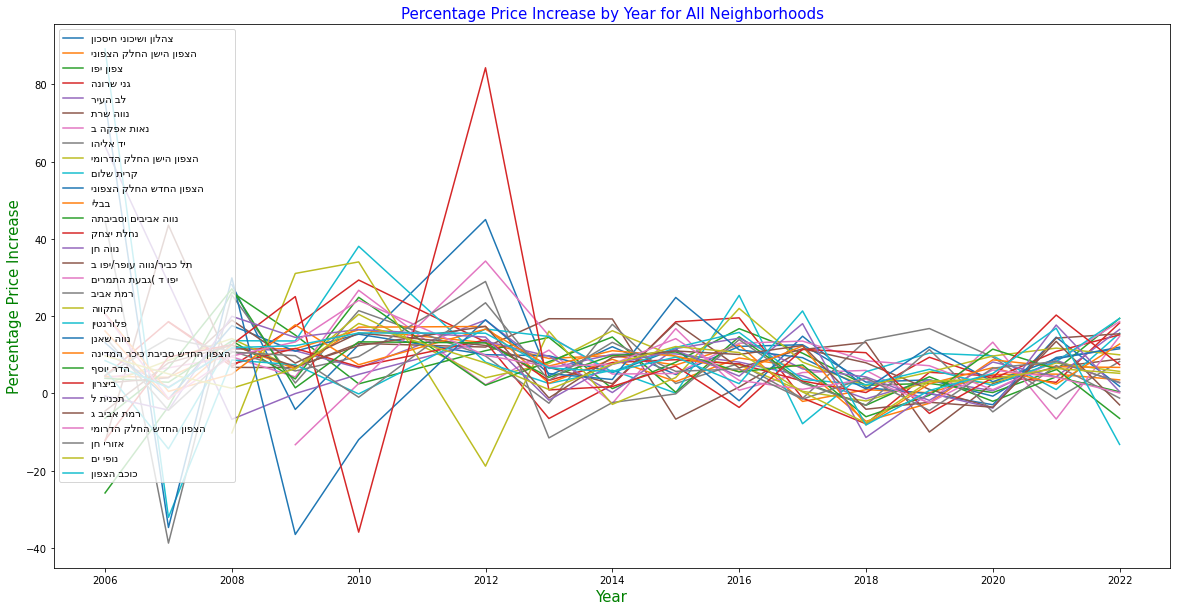

In [24]:
def plot_price_change_all_city(df):
    df = df.dropna(subset=['Price', 'Neighborhood', 'Size']).reset_index(drop=True)
    df = remove_small_amount_deals(df)
    neighborhoods = df['Neighborhood'].unique()
    
    neighborhoods_change_price = {}
    for neighborhood in neighborhoods:
        df_neighborhood = df[df['Neighborhood'] == neighborhood]
        if len(df_neighborhood) < 10:
            continue
        avg_price_meter_data = df_neighborhood.groupby(['Year']).mean()['PRICE_PER_METER']
        price_change = (avg_price_meter_data.diff() / avg_price_meter_data.shift(1)) * 100
        price_change.dropna(inplace=True)
        neighborhoods_change_price[neighborhood] = price_change
        
    plt.figure(figsize=(20,10))    
    plt.title('Percentage Price Increase by Year for All Neighborhoods', color='b', fontsize=15)
    plt.xlabel('Year', color='g', fontsize=15)
    plt.ylabel('Percentage Price Increase', color='g', fontsize=15)
    
    for key, values in neighborhoods_change_price.items():
        plt.plot(values.index, values, label=key[::-1])
        
    plt.legend()
    plt.show()
    
plot_price_change_all_city(nadlan_df)

In [25]:

def plot_avg_seller_ppm(df1, df2):
    # Calculate the average seller PPM(price per meter) for each year in df1 (deal hisory)
    avg_seller_ppm = df1.groupby('Year')['PRICE_PER_METER'].mean()
    df2['PRICE_PER_METER'] = (df2['Price']/df2['Size']).round(1)
    yad2_ppm = df2['PRICE_PER_METER'].mean()

    combined_df = pd.concat([avg_seller_ppm, pd.Series([yad2_ppm], index=[2023])])
    
    # Calculate the change in average seller PPM between each year 
    price_change = (combined_df.diff() / combined_df.shift(1)) * 100

    
    fig, ax = plt.subplots()
    plt.title('PPM change - with available deals (2023-red)', color = 'b', fontsize = 15)

    bars = ax.bar(combined_df.index, combined_df.values)
    
    ax.set_xlabel('Year', fontsize = 12)
    ax.set_ylabel('Average Seller PPM (NIS ₪)')
    plt.figure(figsize=(15,5)) 

    # Add labels above each bar showing the change between each year 
    for i, patch in enumerate(bars):
        if i == len(bars) - 1:
            # Set the color of the last bar to red
            patch.set_color('red')
        ax.text(patch.get_x() + patch.get_width() / 2, patch.get_height() + 0.5,
                '{:.1f}%'.format(price_change.iloc[i]), ha='center', va='bottom')
    
    
    
    fig.set_size_inches(10, 5)
    plt.show()
    
# yad2_df = pd.read_csv("Data/yad_2_data.csv",index_col=0)

plot_avg_seller_ppm(nadlan_df , yad2_df)


KeyError: 'Price'

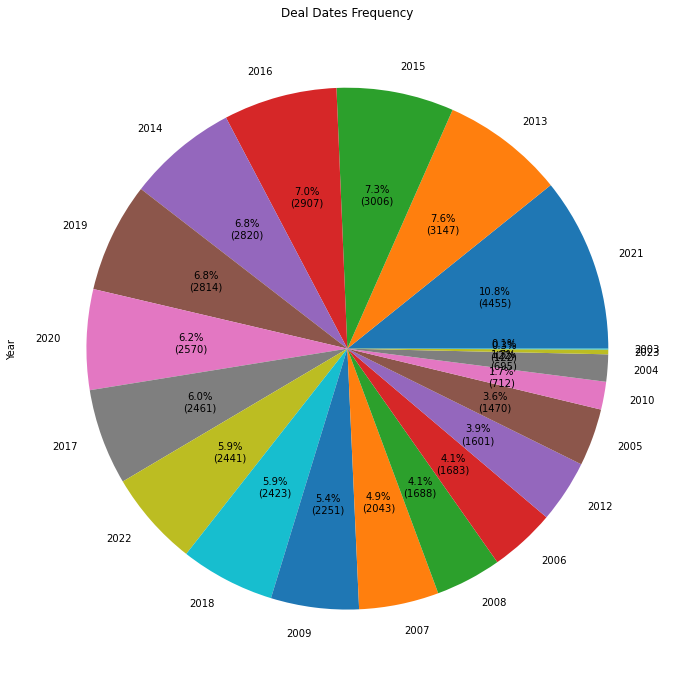

In [26]:
def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d})".format(pct, absolute)



def dealdate_plot(df):
    years_counts=df['Year'].value_counts()
    years_count_sort = years_counts # .sort_values(ascending=True)
    years_count_sort.plot.pie(figsize=(12, 12),autopct=lambda pct: func(pct, years_count_sort) ,labels=years_counts.index,)
    plt.title('Deal Dates Frequency')
    plt.show()
    
dealdate_plot(nadlan_df)

In [ ]:
def LinearRegression_TLV(df):
    avg = df.groupby(['Year']).mean()['PRICE_PER_METER']
    x = np.array(avg.index).reshape(-1,1)
    y = np.array(avg.values).reshape(-1,1)
    linreg = LinearRegression().fit(x,y)
    plt.figure(figsize=(15,5))

    plt.scatter(x,y , label = 'Actual Price')
    ax = plt.gca()

    plt.title('Least Squares', color = 'b', fontsize = 15)
    ax.set_xlabel('Year', color = 'g', fontsize = 15)
    ax.set_ylabel('Price Per Meter', color = 'g', fontsize = 15)
    plt.plot(x,linreg.intercept_+linreg.coef_*x, color='r', label = 'Predicted Price')
    plt.legend()
    plt.show()
LinearRegression_TLV(nadlan_df)


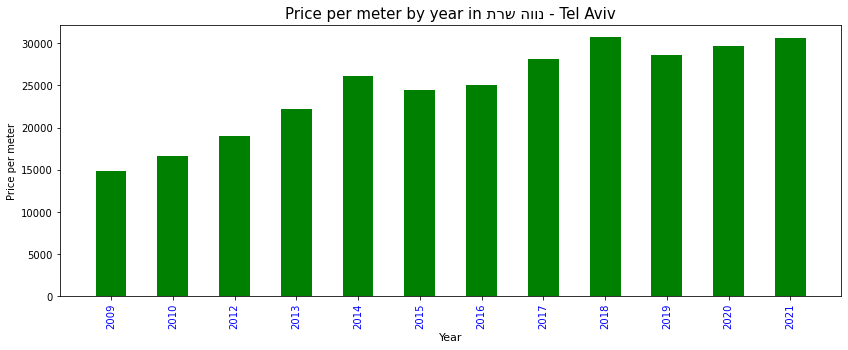

In [33]:
def Price_Increases_Neighborhood(df, neighborhood):
    years = range(2000, 2022)
    price_per_meter_by_year = {}
    for year in years:
        year_data = df[(df["Neighborhood"] == neighborhood) & (df['Year'] == year)]
        if year_data.shape[0] > 10:
            average_price_per_meter = year_data['Price'].sum() / year_data['Size'].sum()
            price_per_meter_by_year[year] = round(average_price_per_meter)
            
    plt.figure(figsize=(14,5))
    bars = tuple(price_per_meter_by_year.keys())
    x_pos = np.arange(len(bars))
    plt.bar(x_pos, price_per_meter_by_year.values(),color = 'g', width = 0.5)
    plt.xticks(x_pos, bars, rotation=90 ,color = 'b')        
    plt.title(f"Price per meter by year in {neighborhood[::-1]} - Tel Aviv" , fontsize= 15)
    plt.xlabel("Year" , color = 'black', fontsize = 11)
    plt.ylabel("Price per meter")
    plt.show()

n = 'נווה שרת'
Price_Increases_Neighborhood(nadlan_df,n)

In [ ]:
def show_map(df1, df2):
    # create a list of points 
    df1 = df1.dropna(subset=['Long','Lat']).reset_index(drop=True)

    points_list1 = [Point(xy) for xy in zip(df1.Long, df1.Lat)]
    points_list2 = [Point(xy) for xy in zip(df2.Long, df2.Lat)]

    # create a geopandas df
    gdf1 = geopandas.GeoDataFrame(df1, geometry=points_list1)
    gdf2 = geopandas.GeoDataFrame(df2, geometry=points_list2)

    # plot the first set of points on the map with red color
    ax = gdf1.plot(figsize=(12, 12), marker='o', color='red', markersize=15, label='History deals')


    # plot the second set of points on the map with blue color
    gdf2.plot(ax=ax, marker='o', color='blue', markersize=15, label='New deals')

    ax.set_title('Real-Estate deals locations -TLV')
    ax.legend()

    plt.show()
    
show_map(nadlan_df, yad2_df)
